<a href="https://colab.research.google.com/github/Kirilica98/omut/blob/main/OMUT_HW6_Zamogilnyi_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import argparse
import os
import math
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import GPT2TokenizerFast
import matplotlib.pyplot as plt

Класс 1-ой архитектуры со сверткой

In [ ]:
import torch.nn.init as init


class CausalConv1d(nn.Module):
    """
    Causal 1D convolution: pads input on the left so that output length equals input length.
    """
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
        super().__init__()
        self.pad = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size,
                              padding=self.pad, dilation=dilation)
        init.xavier_normal_(self.conv.weight)
        init.zeros_(self.conv.bias)

    def forward(self, x):
        x = x.transpose(1, 2)
        y = self.conv(x)
        y = y[:, :, : x.size(2)]
        return y.transpose(1, 2)

class ConvAttentionModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, conv_kernel=3):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.causal_conv = CausalConv1d(embed_dim, embed_dim, kernel_size=conv_kernel)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.to_logits = nn.Linear(embed_dim, vocab_size)

    def forward(self, x, return_attn=False):
        seq_len = x.size(1)
        mask = torch.triu(torch.ones(seq_len, seq_len) * float('-inf'), diagonal=1).to(x.device)

        emb = self.embed(x)
        conv = self.causal_conv(emb)
        attn_out, attn_w = self.attn(
            query=conv,
            key=conv,
            value=conv,
            attn_mask=mask,
            need_weights=return_attn,
            average_attn_weights=False
        )
        logits = self.to_logits(attn_out)
        return (logits, attn_w) if return_attn else logits

Класс Att-Att модели

In [ ]:
class AttentionAttentionModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.attn1 = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.attn2 = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.to_logits = nn.Linear(embed_dim, vocab_size)

    def forward(self, x, return_attn=False):
        seq_len = x.size(1)
        mask = torch.triu(torch.ones(seq_len, seq_len) * float('-inf'), diagonal=1).to(x.device)

        emb = self.embed(x)
        out1, _ = self.attn1(emb, emb, emb, attn_mask=mask)
        out2, attn_w = self.attn2(out1, out1, out1,
                                 attn_mask=mask,
                                 need_weights=return_attn,
                                 average_attn_weights=False)
        logits = self.to_logits(out2)
        return (logits, attn_w) if return_attn else logits

In [ ]:
def prepare_dataset(tokenizer, seq_len, dataset_name="wikitext", subset="wikitext-2-raw-v1"):
    ds = load_dataset(dataset_name, subset)

    def tokenize_fn(examples):
        return tokenizer(examples["text"], return_attention_mask=False)

    tokenized = ds.map(tokenize_fn, batched=True, remove_columns=["text"])

    def group_fn(examples):
        all_ids = sum(examples["input_ids"], [])
        total = len(all_ids)
        total = (total // seq_len) * seq_len
        chunks = [all_ids[i : i + seq_len] for i in range(0, total, seq_len)]
        return {"input_ids": chunks}

    grouped = tokenized.map(group_fn, batched=True)

    grouped.set_format(type="torch", columns=["input_ids"])

    return grouped["train"], grouped["validation"], grouped["test"]

In [ ]:
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0.0
    total_tokens = 0
    correct = 0
    for batch in dataloader:
        x = batch["input_ids"].to(device)
        inputs = x[:, :-1]
        targets = x[:, 1:]
        optimizer.zero_grad()
        logits = model(inputs)
        logits = logits.view(-1, logits.size(-1))
        targets = targets.reshape(-1)
        loss = F.cross_entropy(logits, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * targets.size(0)
        total_tokens += targets.size(0)
        preds = logits.argmax(dim=-1)
        correct += (preds == targets).sum().item()
    return total_loss / total_tokens, correct / total_tokens


def eval_epoch(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    correct = 0
    with torch.no_grad():
        for batch in dataloader:
            x = batch["input_ids"].to(device)
            inputs = x[:, :-1]
            targets = x[:, 1:]
            logits = model(inputs)
            logits = logits.view(-1, logits.size(-1))
            targets = targets.reshape(-1)
            loss = F.cross_entropy(logits, targets)
            total_loss += loss.item() * targets.size(0)
            total_tokens += targets.size(0)
            preds = logits.argmax(dim=-1)
            correct += (preds == targets).sum().item()
    return total_loss / total_tokens, correct / total_tokens

Запустим обучение для модели со сверткой

Epoch 1: train_loss=7.9764, train_acc=0.0659,           val_loss=7.3038, val_acc=0.1116
Epoch 2: train_loss=7.1138, train_acc=0.1206,           val_loss=7.0541, val_acc=0.1296
Epoch 3: train_loss=6.9063, train_acc=0.1306,           val_loss=6.8847, val_acc=0.1369
Epoch 4: train_loss=6.7470, train_acc=0.1374,           val_loss=6.7701, val_acc=0.1444
Epoch 5: train_loss=6.6329, train_acc=0.1429,           val_loss=6.6891, val_acc=0.1489
Epoch 6: train_loss=6.5425, train_acc=0.1472,           val_loss=6.6270, val_acc=0.1524
Epoch 7: train_loss=6.4636, train_acc=0.1507,           val_loss=6.5731, val_acc=0.1552
Epoch 8: train_loss=6.3930, train_acc=0.1538,           val_loss=6.5269, val_acc=0.1580
Epoch 9: train_loss=6.3295, train_acc=0.1566,           val_loss=6.4878, val_acc=0.1602
Epoch 10: train_loss=6.2717, train_acc=0.1590,           val_loss=6.4549, val_acc=0.1629
Epoch 11: train_loss=6.2189, train_acc=0.1615,           val_loss=6.4207, val_acc=0.1651
Epoch 12: train_loss=6.1700, t

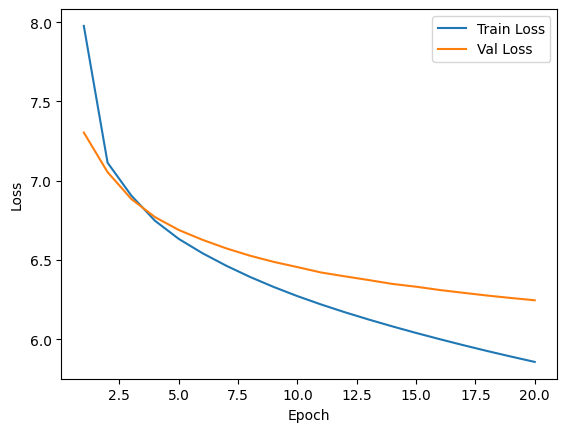

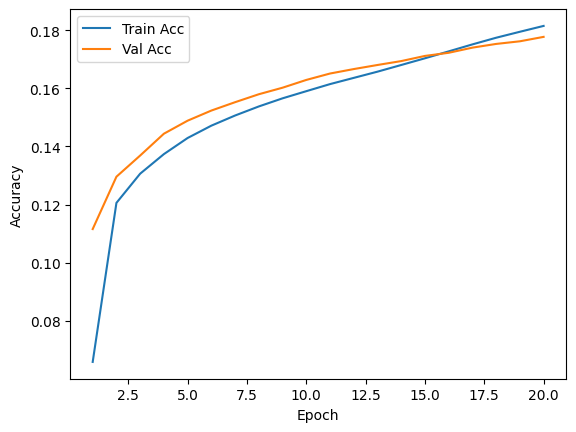

In [ ]:
args = {
'model': 'conv-attn',
'seq_len': 128,
'batch_size': 32,
'epochs': 20,
'lr': 1e-4,
'embed_dim': 128,
'num_heads': 4,
'dataset': 'wikitext',
'subset': 'wikitext-2-raw-v1',
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')

train_ds, val_ds, _ = prepare_dataset(tokenizer, args['seq_len'] + 1,
                                      dataset_name=args['dataset'],
                                      subset=args['subset'])
train_loader = DataLoader(train_ds, batch_size=args['batch_size'], shuffle=True)
val_loader = DataLoader(val_ds, batch_size=args['batch_size'])

vocab_size = tokenizer.vocab_size
if args['model'] == 'conv-attn':
    model = ConvAttentionModel(vocab_size,args['embed_dim'], args['num_heads'])
else:
    model = AttentionAttentionModel(vocab_size,args['embed_dim'], args['num_heads'])
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
for epoch in range(1, args['epochs'] + 1):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    val_loss, val_acc = eval_epoch(model, val_loader, device)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    print(f"Epoch {epoch}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, \
          val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

# Plot training curves
epochs = range(1, args['epochs'] + 1)
plt.figure()
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_curve_conv.png')

plt.figure()
plt.plot(epochs, history['train_acc'], label='Train Acc')
plt.plot(epochs, history['val_acc'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('acc_curve_conv.png')

# Save model and convolutional weights for analysis
os.makedirs('checkpoints', exist_ok=True)
torch.save(model.state_dict(), f"checkpoints/{args['model']}_final.pt")

Визуализируем веса на определенных каналах и их статистики.

Средние значения по позициям ядра:
i-2: 0.0004
i-1: -0.0005
i: 0.0002



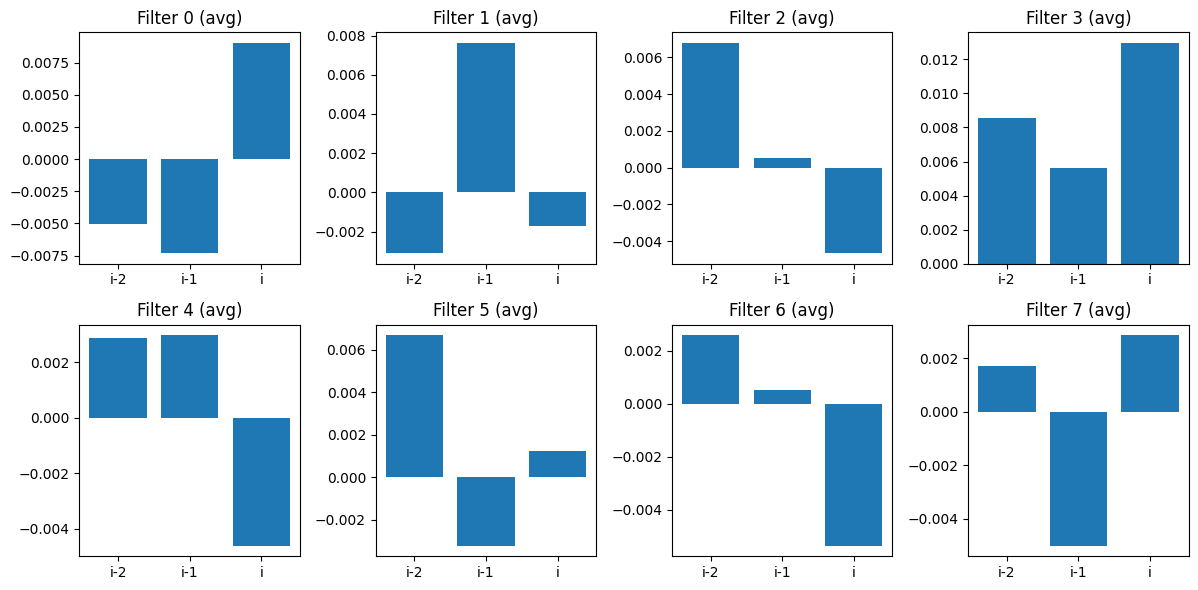

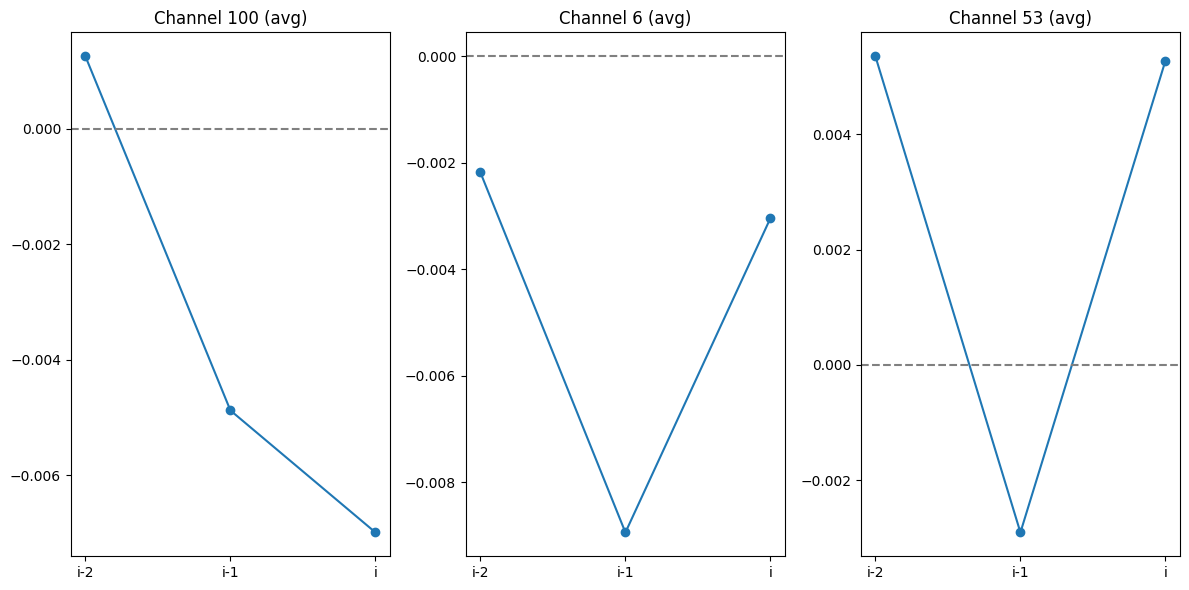

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def analyze_conv_weights(model):
    """Анализ весов сверточного слоя для проверки концепции 'smeared keys'"""
    weights = model.causal_conv.conv.weight.data.cpu().numpy()
    out_channels, in_channels, kernel_size = weights.shape

    # 1. Статистика по позициям ядра
    kernel_pos_stats = {
        'mean': weights.mean(axis=(0,1)),  # [kernel_size]
        'median': np.median(weights, axis=(0,1))
    }

    print("Средние значения по позициям ядра:")
    print(f"i-{kernel_size-1}: {kernel_pos_stats['mean'][0]:.4f}")
    print(f"i-1: {kernel_pos_stats['mean'][1]:.4f}")
    print(f"i: {kernel_pos_stats['mean'][-1]:.4f}\n")

    # 2. Визуализация усредненных фильтров
    plt.figure(figsize=(12, 6))
    for i in range(min(8, out_channels)):
        plt.subplot(2, 4, i+1)
        avg_weights = weights[i].mean(axis=0)
        plt.bar(range(kernel_size), avg_weights)
        plt.title(f"Filter {i} (avg)")
        plt.xticks(range(kernel_size), [f"i-{kernel_size-1}", "i-1", "i"])
    plt.tight_layout()
    plt.savefig("conv_avg_filters.png")
    plt.show()
    plt.close()

    # 3. Визуализация наиболее важных каналов
    channel_importance = np.abs(weights).mean(axis=(0,2))  # [in_channels]
    top_channels = np.argsort(channel_importance)[-3:]  # Топ-3 канала

    plt.figure(figsize=(12, 6))
    for idx, ch in enumerate(top_channels):
        plt.subplot(1, 3, idx+1)
        ch_weights = weights[:, ch, :].mean(axis=0)
        plt.plot(range(kernel_size), ch_weights, marker='o')
        plt.title(f"Channel {ch} (avg)")
        plt.xticks(range(kernel_size), [f"i-{kernel_size-1}", "i-1", "i"])
        plt.axhline(0, color='grey', linestyle='--')
    plt.tight_layout()
    plt.savefig("conv_top_channels.png")
    plt.show()
    plt.close()

    return kernel_pos_stats

# Использование
if args['model'] == 'conv-attn':
    stats = analyze_conv_weights(model)

Посмотрим на attention мапу

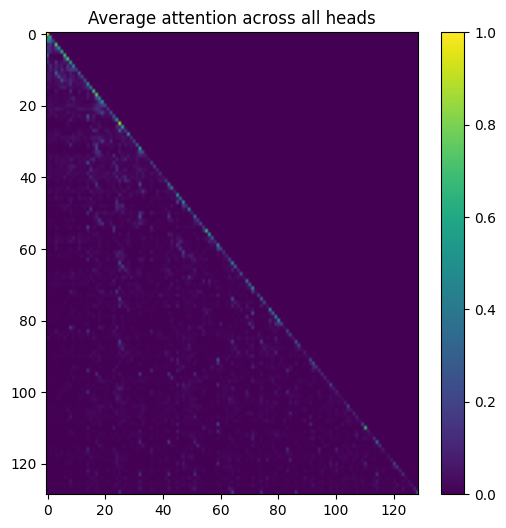

In [ ]:
model.eval()
sample = next(iter(val_loader))["input_ids"][:1].to(device)
with torch.no_grad():
    logits, attn_w = model(sample, return_attn=True)
attn_map = attn_w.cpu().numpy()[0]  # shape: [num_heads, seq_len, seq_len]
num_heads = attn_map.shape[0]
for h in range(num_heads):
    plt.figure(figsize=(5, 5))
    plt.imshow(attn_map[h], aspect='auto')
    plt.title(f'Attention map — head {h}')
    plt.colorbar()
    plt.savefig(f'conv_attn_head_{h}.png')
    plt.close()
mean_map = attn_map.mean(axis=0)
plt.figure(figsize=(6, 6))
plt.imshow(mean_map, aspect='auto')
plt.title('Average attention across all heads')
plt.colorbar()
plt.savefig('attn_mean.png')

Перейдем ко второй модели

Epoch 1: train_loss=8.0283, train_acc=0.0429,           val_loss=7.5219, val_acc=0.0512
Epoch 2: train_loss=7.4116, train_acc=0.0581,           val_loss=7.2797, val_acc=0.0842
Epoch 3: train_loss=7.0748, train_acc=0.1081,           val_loss=7.0167, val_acc=0.1185
Epoch 4: train_loss=6.8880, train_acc=0.1220,           val_loss=6.8952, val_acc=0.1286
Epoch 5: train_loss=6.7822, train_acc=0.1272,           val_loss=6.8305, val_acc=0.1311
Epoch 6: train_loss=6.7156, train_acc=0.1298,           val_loss=6.7842, val_acc=0.1336
Epoch 7: train_loss=6.6619, train_acc=0.1317,           val_loss=6.7435, val_acc=0.1352
Epoch 8: train_loss=6.6122, train_acc=0.1337,           val_loss=6.7112, val_acc=0.1365
Epoch 9: train_loss=6.5623, train_acc=0.1355,           val_loss=6.6734, val_acc=0.1387
Epoch 10: train_loss=6.5129, train_acc=0.1377,           val_loss=6.6475, val_acc=0.1403
Epoch 11: train_loss=6.4669, train_acc=0.1399,           val_loss=6.6144, val_acc=0.1426
Epoch 12: train_loss=6.4245, t

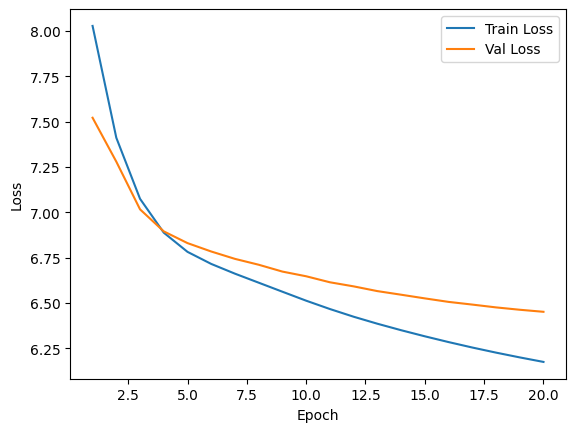

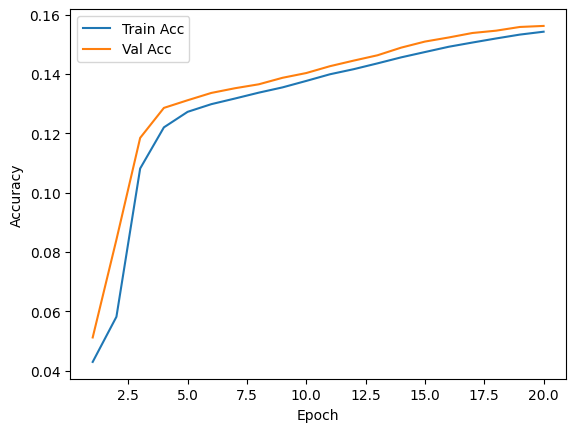

In [ ]:
args = {
'model': 'attn-attn',
'seq_len': 128,
'batch_size': 32,
'epochs': 20,
'lr': 1e-4,
'embed_dim': 128,
'num_heads': 4,
'dataset': 'wikitext',
'subset': 'wikitext-2-raw-v1',
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')

train_ds, val_ds, _ = prepare_dataset(tokenizer, args['seq_len'] + 1,
                                      dataset_name=args['dataset'],
                                      subset=args['subset'])
train_loader = DataLoader(train_ds, batch_size=args['batch_size'], shuffle=True)
val_loader = DataLoader(val_ds, batch_size=args['batch_size'])

vocab_size = tokenizer.vocab_size
if args['model'] == 'conv-attn':
    model = ConvAttentionModel(vocab_size,args['embed_dim'], args['num_heads'])
else:
    model = AttentionAttentionModel(vocab_size,args['embed_dim'], args['num_heads'])
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
for epoch in range(1, args['epochs'] + 1):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    val_loss, val_acc = eval_epoch(model, val_loader, device)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    print(f"Epoch {epoch}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, \
          val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

epochs = range(1, args['epochs'] + 1)
plt.figure()
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_curve.png')

plt.figure()
plt.plot(epochs, history['train_acc'], label='Train Acc')
plt.plot(epochs, history['val_acc'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('acc_curve.png')

os.makedirs('checkpoints', exist_ok=True)
torch.save(model.state_dict(), f"checkpoints/{args['model']}_final.pt")

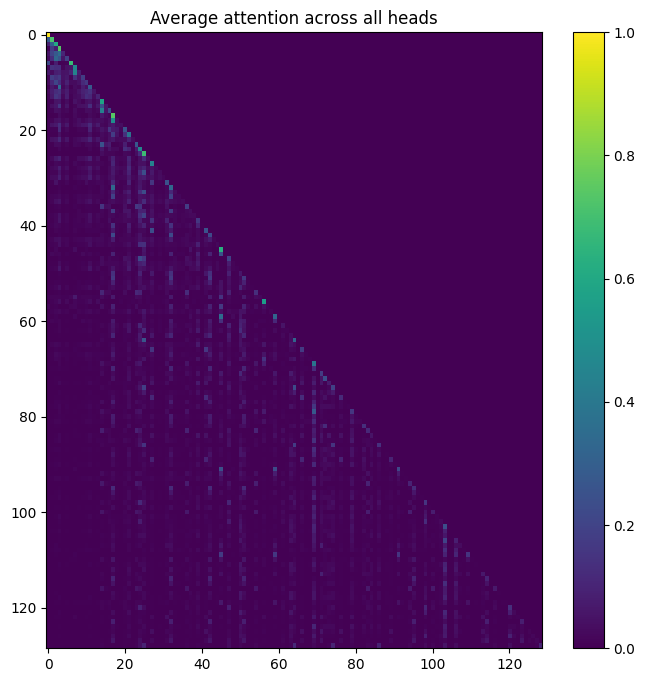

In [ ]:
model.eval()
sample = next(iter(val_loader))["input_ids"][:1].to(device)
with torch.no_grad():
    logits, attn_w = model(sample, return_attn=True)
attn_map = attn_w.cpu().numpy()[0]
num_heads = attn_map.shape[0]
for h in range(num_heads):
    plt.figure(figsize=(5, 5))
    plt.imshow(attn_map[h], aspect='auto')
    plt.title(f'Attention map — head {h}')
    plt.colorbar()
    plt.savefig(f'attn_head_{h}.png')
    plt.close()
mean_map = attn_map.mean(axis=0)
plt.figure(figsize=(8, 8))
plt.imshow(mean_map, aspect='auto')
plt.title('Average attention across all heads')
plt.colorbar()
plt.savefig('attn_mean.png')
